In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sbi.analysis import pairplot
import pickle
import scipy
import yaml
import os
from sbc.sbc_tools import plot_sbc_all
from examples.gipps import plot_all

path_to_repo = "/Users/Lieve/Documents/Masters Project/SBC-SBI"
results_path = path_to_repo + "/results/real_examples/gipps_7d/npe_c"
trajectories_path = path_to_repo + "/results/real_examples/gipps_7d/trajectories"

In this experiment, we use SBC to validate SBI methods applied to the Gipps car following model (original paper: https://www.sciencedirect.com/science/article/pii/0191261581900370). We follow the experiments used in https://www.sciencedirect.com/science/article/pii/S0378437124001808?fr=RR-2&ref=pdf_download&rr=9a4270eb8b679466, who apply Bayesian inference (MCMC) to infer the parameters of the Gipps ODE that generated a given follower trajectory. Instead of MCMC, we apply SBI to the inference problem, and then validate these trained SBI models using SBC. No code was provided by the authors, so a direct comparison to their methodology is not possible.

The Gipps model is a (non-stochastic) differential equation that can be solved to obtain the displacement time series $\{x^\text{Gipps}_f(t) : t \in [0,T]\}$ of a follower car, given a leader car's trajectory $\{(x_l(t), v_l(t)) : t \in [0,T]\}$ and some driver-specific ODE parameters $(a_f, b_f, V_f, x_f(0), v_f(0), \tau, \ell_l, \Psi, b_l)$, where

- $a_f$: Maximum acceleration of the follower vehicle.

- $b_f$: Maximum deceleration (braking) of the follower vehicle. Note that $b_f < 0$.

- $V_f$: Desired maximum velocity of the follower vehicle. If in free-flow (no congestion), the driver will accelerate to $V_f$ and remain at this velocity indefinitely. 

- $x_f(0)$: Initial position of the follower vehicle.

- $v_f(0)$: Initial velocity of the follower vehicle. 

- $\tau$: Driver reaction time (the time delay before the follower responds to changes in the leader’s motion).

- $\ell_l$: Effective length of the leader vehicle.

- $\Psi$: Anticipation factor representing how well the follower intereprets the leader’s maximum braking. In particular, the follower's best guess of the leaders maximum braking is $\Psi b_l$.

- $b_l$: Maximum deceleration of the leader vehicle.

In applications, the differential equation is discretised into $N+1$ discrete time points to become a difference equation on the grid $\{0, \frac{T}{N}, ..., \frac{T(N-1)}{N}, T\}$. Interestingly, practitioners often take the discretization gap $\frac{T}{N}$ to be the driver's reaction time $\tau$, which makes sense intuitively, but makes Bayesian inference on $\tau$ impossible (since $\tau$ is the discretization width of the data, so must be known during data collection). For this reason, we hold $\tau$ constant throughout the problem (we take the default to be $0.5s$, in-line with reality). We also hold constant the following variables to reduce the number of variables to infer:

- The maximum deceleration $b_l$ of the leader vehicle (default $-4ms^{-1}$ )

- The anticipation factor $\Psi$ (default $1.05$).

- The effective length $\ell_l$ of the leader vehicle (default $7.5m$).

For $t \in \{0, \frac{T}{N}, ..., \frac{T(N-1)}{N}\}$, the difference equation is

$$v_f(t + \tau) = \min\!\big( v_{ff}(t + \tau)\ v_{cf}(t + \tau) \big)$$

$$v_{ff}(t + \tau)  = v_f(t)  + 2.5\ a_{f}\ \tau  \left( 1 - \frac{v_f(t)}{V_{f}} \right) \sqrt{0.025 + \frac{v_f(t)}{V_{f}}}$$

$$v_{cf}(t + \tau)
= b_{f}\ \tau + \sqrt{b_{f}^2 \tau^2 - b_{f} \left[ 2\big(x_l(t) - \ell_l - x_f(t)\big) - v_f(t)\ \tau - \frac{v_l^2(t)}{\Psi b_l} \right] }$$

Given 

- The discretized leader trajectory $\{(x_l(t), v_l(t)) : t \in \{0, \tau, 2\tau, ..., T-\tau, T\}\}$
- Parameters $(a_f, b_f, V_f, b_l, x_f(0), v_f(0))$ (and $(\tau, \ell_l, \Psi, b_l)$, but these are fixed throughout)

we can use the difference equation above to compute (deterministically) the follower trajectory 

$$\{(x^\text{Gipps}_f(t), v^\text{Gipps}_f(t)) : t \in \{0, \tau, 2\tau, ..., T-\tau, T\}\}$$

In pseudocode, we can express the Gipps ODE solver as:

$$x^\text{Gipps}_f, v^\text{Gipps}_f = \texttt{generate\_follower\_trajectory}(a_f, b_f, V_f, x_f(0), v_f(0), x_l, v_l)$$

Note that solving the Gipps equation gives the follower velocity time series, but using the first-order approximation $x^\text{Gipps}_f(t + \tau) = x^\text{Gipps}_f(t) + \frac{1}{2} \tau (v^\text{Gipps}_f(t) + v^\text{Gipps}_f(t + \tau)))$ we obtain the follower displacement time series and therefore the full follower trajectory (we define a trajectory as the displacement and velocity time series). Since our analysis depends only on the follower's displacement time series, we discard the velocity time series after this step.

To define our simulator, we further account for noise in the measurement devices used to observe the follower displacement time series. Specifically, we add Gaussian noise with mean $\mu \in \mathbb{R}^N$ and covariance $\sigma^2 I_{N \times N}$ to the Gipps displacement time series ${x^\text{Gipps}_f(t) : t \in {0, \tau, 2\tau, \ldots, T-\tau, T}}$, yielding the “stochastic” follower displacement time series ${x_f(t) : t \in {0, \tau, 2\tau, \ldots, T-\tau, T}}$. The sole source of stochasticity in the simulator is this Gaussian measurement noise. To be concrete, we wish to use SBI to infer the parameters $(a_f, b_f, V_f, x_f(0), v_f(0), \mu, \sigma^2)$, whereas we hold fixed the parameters $(N, T, \tau, b_l, \Phi, \ell_l)$. We can express our simulator in pseudocode as

$$x_f = \texttt{simulator}(a_f, b_f, V_f, x_f(0), v_f(0), \mu, \sigma^2, x_l, v_l)$$

In our experiments, we assumed the leader car follows the Gipps’ free flow component ($v_{ff}$ above), with random acceleration/deceleration perturbations imposed at each time step to simulate typical driving conditions (i.e. the leader will accelerate/brake accoriding to its leader, etc...). 

We place priors over the parameters $(a_f, b_f, V_f, x_f(0), v_f(0), \mu, \sigma^2)$ we wish to infer, and apply various SBI methods to retrieve the posterior $p\left(a_f, b_f, V_f, x_f(0), v_f(0), \mu, \sigma^2 | x_f ; x_l, v_l\right)$.

# Amortized NPE-C to infer Gipps parameters

In [3]:
# We assume the following variables are fixed globally:
tau = 0.5
N = 200  # Number of tau-sized time steps to simulate
T = tau * N  # Total time simulated
psi = 1.05
ll = 7.5 # Length of leader car

# True follower parameters
af = 1.797
bf = -3.566
Vf = 28
xf0 = -22.521
vf0 = 10.148
mu = 0.8
sigmasquared = 0.25

# Define true parameter vector
true_theta = torch.tensor([af, bf, Vf, xf0, vf0, mu, sigmasquared])

# True leader parameters (all of these apart from bl are only needed for simulating leader trajectory).
# Note that these were not given in the paper
al = 2
bl = -4
Vl = 30
xl0 = 0
vl0 = 10
p_accel = 0.2
p_brake = 0.2

Retrieve the leader trajectory, which is fixed throughout the problem.

In [4]:
# Select leader trajectory ID
leader_trajectory_ID = 0

leader_trajectory_name = f"leader_trajectory{leader_trajectory_ID}"
path_to_leader_trajectory = trajectories_path + "/" + leader_trajectory_name + ".npz"
path_to_leader_trajectory_config = trajectories_path + "/" + leader_trajectory_name + ".yaml"

# Retrieve xl, vl
leader_trajectory = np.load(path_to_leader_trajectory)
xl = leader_trajectory["xl"]
vl = leader_trajectory["vl"]

# Retrieve leader trajectory config
with open(path_to_leader_trajectory_config, "r") as f:
    leader_trajectory_config = yaml.safe_load(f) # Dictionary containing all information about xl, vl

Retrieve the observed follower trajectory that we condition our inference on.

In [5]:
# Select observed follower trajectory ID
follower_trajectory_ID = 0

follower_trajectory_name = f"follower_trajectory{follower_trajectory_ID}_leader_trajectory{leader_trajectory_ID}"
path_to_follower_trajectory = trajectories_path + "/" + follower_trajectory_name + ".npz"
path_to_follower_trajectory_config = trajectories_path + "/" + follower_trajectory_name + ".yaml"

# Retrieve xf_obs, vf_obs
follower_trajectory = np.load(path_to_follower_trajectory)
xf_obs = follower_trajectory["xf"]
vf_obs = follower_trajectory["vf"]

# Retrieve follower trajectory config
with open(path_to_follower_trajectory_config, "r") as f:
    follower_trajectory_config = yaml.safe_load(f) # Dictionary containing all information about xf, vf

Plot follower and leader trajectories.

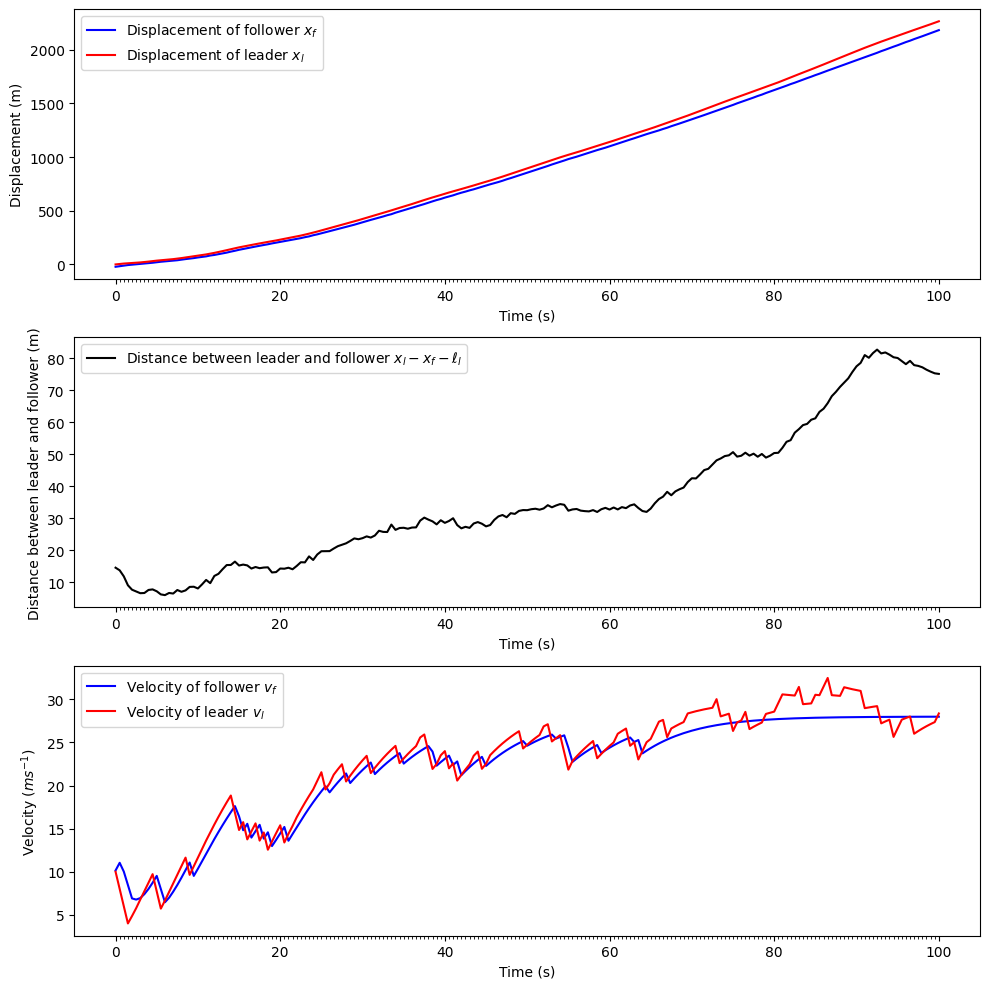

In [6]:
plot_all(xf_obs, vf_obs, xl, vl, tau, N, ll)

Denote the parameter vector as

$$\theta = (a_f, b_f, V_f, x_f(0), v_f(0), \mu, \sigma^2)$$

In [8]:
# Define prior hyperparameters
# This is the exact prior used in the paper
aL, aU = 0.5, 3.5
bL, bU = -6, -1
VL, VU = 15, 35
xf0L, xf0U = -60, -10
vf0L, vf0U = 5, 25
prior_mean_mu, prior_variance_mu = 0., 9.
prior_alpha_sigmasquared, prior_beta_sigmasquared = 1., 3.

# Define prior supports only for the 5 uniform parameters
prior_supports = [(aL, aU), (bL, bU), (VL, VU), (xf0L, xf0U), (vf0L, vf0U)]

In [9]:
# Select amortized posterior ID
amortized_posterior_ID = 0

amortized_posterior_name = f"amortized_posterior{amortized_posterior_ID}_leader_trajectory{leader_trajectory_ID}"
path_to_amortized_posterior = results_path + "/" + amortized_posterior_name + ".pkl"
path_to_amortized_posterior_config = results_path + "/" + amortized_posterior_name + ".yaml"

# Retrieve amortized posterior
with open(path_to_amortized_posterior, "rb") as f:
    amortized_posterior = pickle.load(f)

# Retrieve amortized posterior config
with open(path_to_amortized_posterior_config, "r") as f:
    amortized_posterior_config = yaml.safe_load(f) # Dictionary containing all information about this posterior.

In [10]:
amortized_posterior_samples = amortized_posterior.sample((10000,), x=xf_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Clear non-identifiability issue with $x_f(0)$ and $v_f(0)$ (look at the correlations). Since if we start further back but have a larger initial velocity, we can achieve a very similar trajectory.

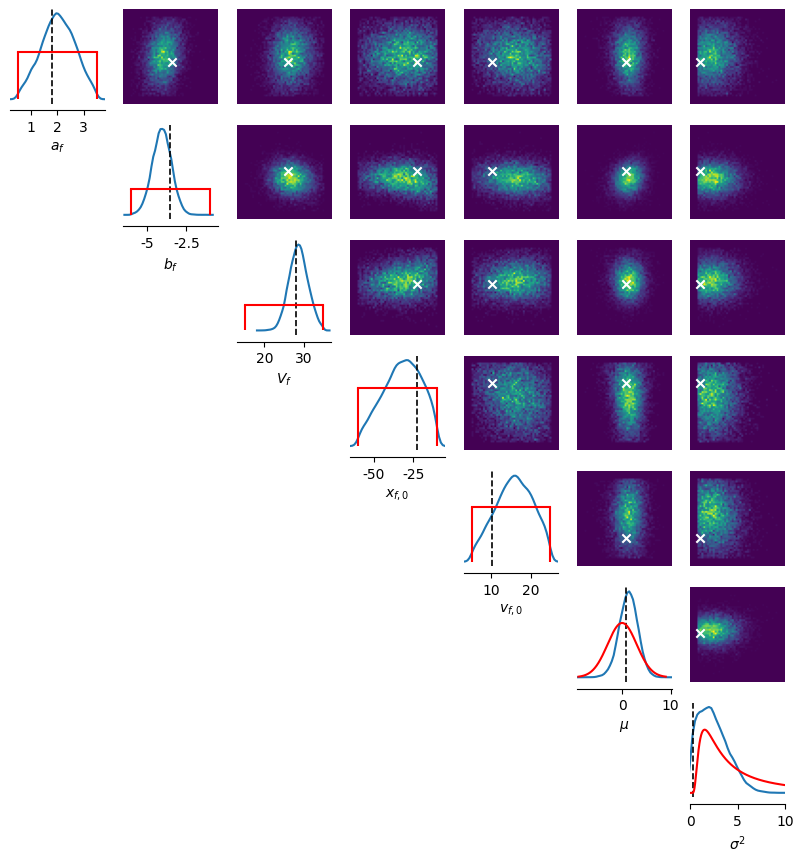

In [13]:
parameter_labels = [r"$a_f$", r"$b_f$", r"$V_f$", r"$x_{f,0}$", r"$v_{f,0}$", r"$\mu$", r"$\sigma^2$"]

fig = pairplot(amortized_posterior_samples,
         labels=parameter_labels,
         figsize=(10,10),
         diag="kde")

axes = fig[0].axes   # flat list of all subplots
dim = len(true_theta)

for i in range(dim):        # row index
    for j in range(dim):    # column index
        ax = axes[i * dim + j]

        if i == j:
            # Plot vertical line at true parameter value
            ax.axvline(true_theta[i], color="black", linestyle="--", linewidth=1.2)

            if i <= 4:
                L = prior_supports[i][0]
                U = prior_supports[i][1]
                x = np.linspace(L, U, 1000)
                y = np.where((x >= L) & (x <= U), 1 / (U - L), 0.0)
                ax.plot(x, y, color="red")
                ax.vlines(x=L, ymin=0, ymax=1/(U-L), color="red")
                ax.vlines(x=U, ymin=0, ymax=1/(U-L), color="red")
                ax.set_xlim((L - 0.1*abs(U-L), U + 0.1*abs(U-L)))
            elif i == 5:
                x = np.linspace(prior_mean_mu - 3 * np.sqrt(prior_variance_mu),
                                prior_mean_mu + 3 * np.sqrt(prior_variance_mu),
                                1000)
                y = scipy.stats.norm.pdf(x, loc=prior_mean_mu, scale=np.sqrt(prior_variance_mu))
                ax.plot(x, y, color="red")
            else:
                L, U = 0, 10
                ax.set_xlim((L,U))
                x = np.linspace(L, U, 1000)
                y = scipy.stats.invgamma.pdf(x, a=prior_alpha_sigmasquared, scale=prior_beta_sigmasquared)
                ax.plot(x, y, color="red")

        elif j > i:
            # 2D joint → horizontal AND vertical lines
            ax.scatter(true_theta[j], true_theta[i], color="white", marker="x")

## SBC on amortized NPE-C

In [14]:
amortized_sbc_ID = 0

path_to_amortized_sbc = results_path + f"/amortized_sbc{amortized_sbc_ID}_amortized_posterior{amortized_posterior_ID}_leader_trajectory{leader_trajectory_ID}" + ".npy"
path_to_amortized_sbc_config = results_path + f"/amortized_sbc{amortized_sbc_ID}_amortized_posterior{amortized_posterior_ID}_leader_trajectory{leader_trajectory_ID}" + ".yaml"

# Retrieve amortized sbc ranks
amortized_ranks = np.load(path_to_amortized_sbc)

# Retrieve amortized sbc config
with open(path_to_amortized_sbc_config, "r") as f:
    amortized_sbc_config = yaml.safe_load(f) # Dictionary containing all information about this sbc run.

# Get N_iter and N_samp from config file
N_iter = amortized_sbc_config["sbc_config"]["N_iter"]
N_samp = amortized_sbc_config["sbc_config"]["N_samp"]

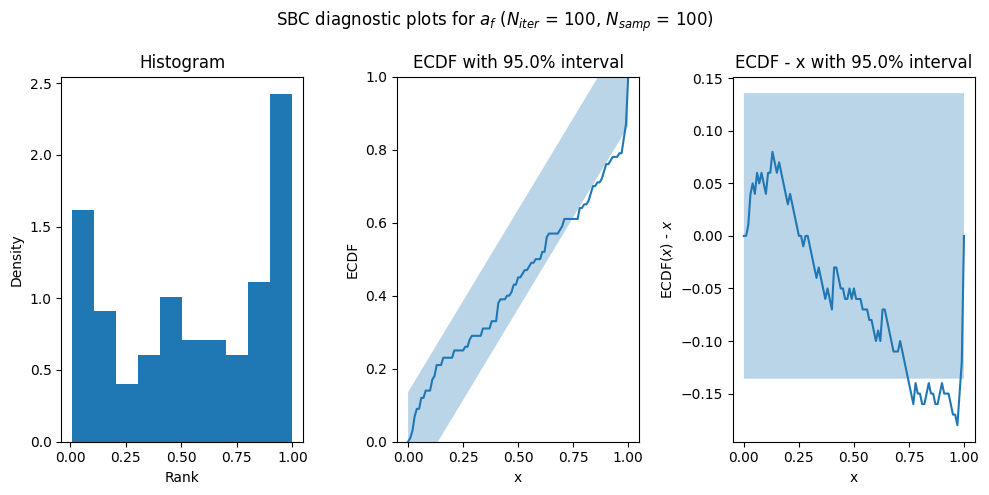

array([<Axes: title={'center': 'Histogram'}, xlabel='Rank', ylabel='Density'>,
       <Axes: title={'center': 'ECDF with 95.0% interval'}, xlabel='x', ylabel='ECDF'>,
       <Axes: title={'center': 'ECDF - x with 95.0% interval'}, xlabel='x', ylabel='ECDF($x$) - $x$'>],
      dtype=object)

In [ ]:
title=fr"SBC diagnostic plots for {parameter_labels[0]}" + r" ($N_{iter}$ = " + f"{N_iter}, " + r"$N_{samp}$ = " + f"{N_samp})"
plot_sbc_all(ranks=amortized_ranks, N_samp=N_samp, title=title)

# Sequential NPE-C (SNPE-C) to infer Gipps parameters

In [21]:
sequential_posterior_ID = 0

path_to_sequential_posterior = results_path + f"/sequential_posterior{sequential_posterior_ID}_follower_trajectory{follower_trajectory_ID}_leader_trajectory{leader_trajectory_ID}" + ".pkl"
path_to_sequential_posterior_config = results_path + f"/sequential_posterior{sequential_posterior_ID}_follower_trajectory{follower_trajectory_ID}_leader_trajectory{leader_trajectory_ID}" + ".yaml"

with open(path_to_sequential_posterior, "rb") as f:
    sequential_posterior = pickle.load(f)

# Retrieve sequential posterior config
with open(path_to_sequential_posterior_config, "r") as f:
    sequential_posterior_config = yaml.safe_load(f) # Dictionary containing all information about this posterior.

In [24]:
sequential_posterior_samples = sequential_posterior.sample((10000,), x=xf_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

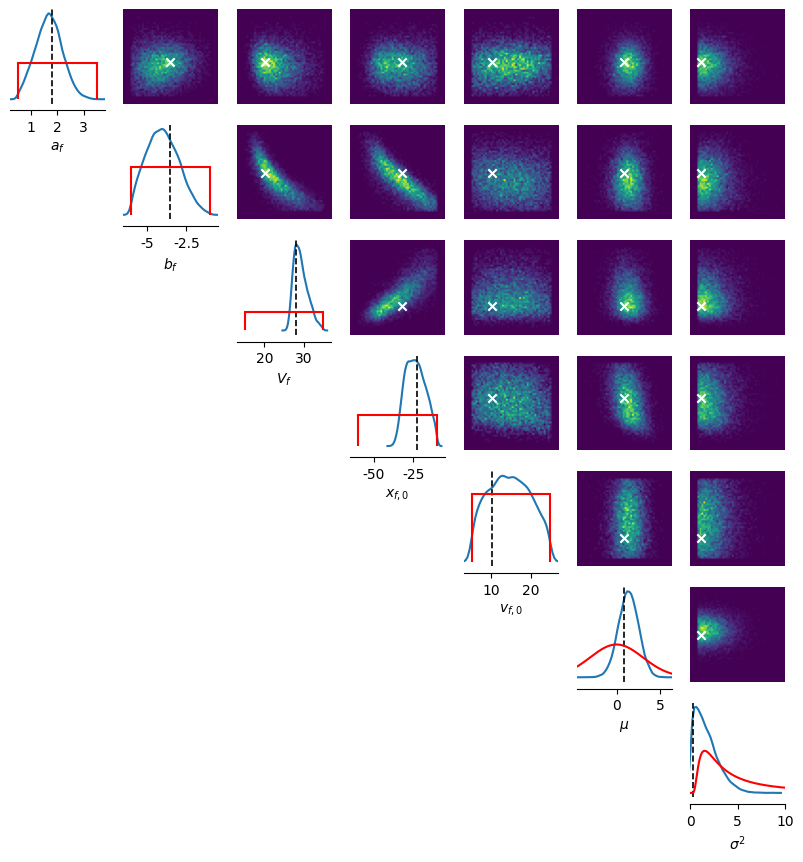

In [25]:
parameter_labels = [r"$a_f$", r"$b_f$", r"$V_f$", r"$x_{f,0}$", r"$v_{f,0}$", r"$\mu$", r"$\sigma^2$"]

fig = pairplot(sequential_posterior_samples,
         labels=parameter_labels,
         figsize=(10,10),
         diag="kde")

axes = fig[0].axes   # flat list of all subplots
dim = len(true_theta)

for i in range(dim):        # row index
    for j in range(dim):    # column index
        ax = axes[i * dim + j]

        if i == j:
            # Plot vertical line at true parameter value
            ax.axvline(true_theta[i], color="black", linestyle="--", linewidth=1.2)

            if i <= 4:
                L = prior_supports[i][0]
                U = prior_supports[i][1]
                x = np.linspace(L, U, 1000)
                y = np.where((x >= L) & (x <= U), 1 / (U - L), 0.0)
                ax.plot(x, y, color="red")
                ax.vlines(x=L, ymin=0, ymax=1/(U-L), color="red")
                ax.vlines(x=U, ymin=0, ymax=1/(U-L), color="red")
                ax.set_xlim((L - 0.1*abs(U-L), U + 0.1*abs(U-L)))
            elif i == 5:
                x = np.linspace(prior_mean_mu - 3 * np.sqrt(prior_variance_mu),
                                prior_mean_mu + 3 * np.sqrt(prior_variance_mu),
                                1000)
                y = scipy.stats.norm.pdf(x, loc=prior_mean_mu, scale=np.sqrt(prior_variance_mu))
                ax.plot(x, y, color="red")
            else:
                L, U = 0, 10
                ax.set_xlim((L,U))
                x = np.linspace(L, U, 1000)
                y = scipy.stats.invgamma.pdf(x, a=prior_alpha_sigmasquared, scale=prior_beta_sigmasquared)
                ax.plot(x, y, color="red")

        elif j > i:
            # 2D joint → horizontal AND vertical lines
            ax.scatter(true_theta[j], true_theta[i], color="white", marker="x")

## SBC on SNPE-C

In [26]:
sequential_sbc_ID = 0

path_to_sequential_sbc = results_path + f"/sequential_sbc{sequential_sbc_ID}_leader_trajectory{leader_trajectory_ID}" + ".npy"
path_to_sequential_sbc_config = results_path + f"/sequential_sbc{sequential_sbc_ID}_leader_trajectory{leader_trajectory_ID}" + ".yaml"

# Retrieve sequential sbc ranks
sequential_ranks = np.load(path_to_sequential_sbc)

# Retrieve sequential sbc config
with open(path_to_sequential_sbc_config, "r") as f:
    sequential_sbc_config = yaml.safe_load(f) # Dictionary containing all information about this sbc run.

# Get N_iter and N_samp from config file
N_iter = sequential_sbc_config["sbc_config"]["N_iter"]
N_samp = sequential_sbc_config["sbc_config"]["N_samp"]

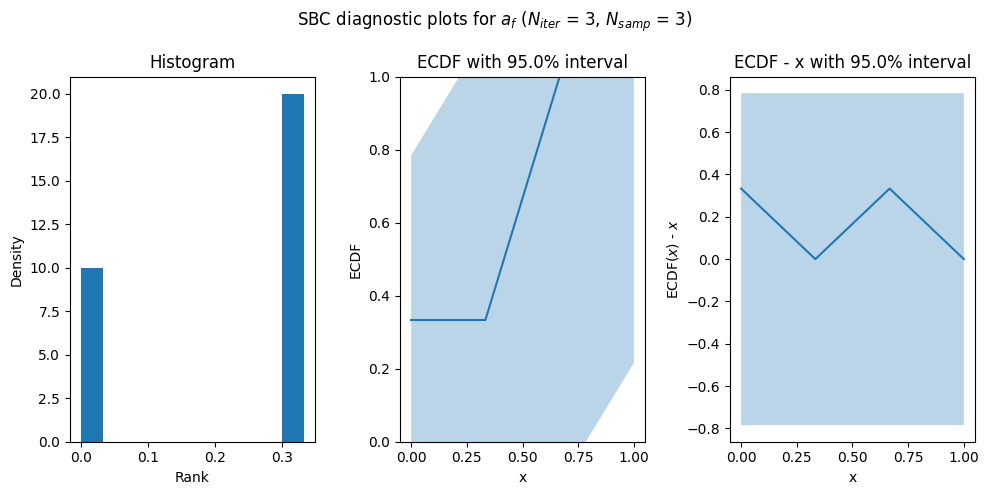

array([<Axes: title={'center': 'Histogram'}, xlabel='Rank', ylabel='Density'>,
       <Axes: title={'center': 'ECDF with 95.0% interval'}, xlabel='x', ylabel='ECDF'>,
       <Axes: title={'center': 'ECDF - x with 95.0% interval'}, xlabel='x', ylabel='ECDF($x$) - $x$'>],
      dtype=object)

In [ ]:
title=fr"SBC diagnostic plots for {parameter_labels[0]}" + r" ($N_{iter}$ = " + f"{N_iter}, " + r"$N_{samp}$ = " + f"{N_samp})"
plot_sbc_all(ranks=sequential_ranks, N_samp=N_samp, title=title)